In [ ]:
# https://github.com/NBoulle/RationalNets
# https://arxiv.org/abs/2004.01902

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# rational layer

In [5]:
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers, constraints

In [6]:
class RationalLayer(Layer):
    """Rational Activation function.
    It follows:
    `f(x) = P(x) / Q(x),
    where the coefficients of P and Q are learned array with the same shape as x.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        alpha_initializer: initializer function for the weights of the numerator P.
        beta_initializer: initializer function for the weights of the denominator Q.
        alpha_regularizer: regularizer for the weights of the numerator P.
        beta_regularizer: regularizer for the weights of the denominator Q.
        alpha_constraint: constraint for the weights of the numerator P.
        beta_constraint: constraint for the weights of the denominator Q.
        shared_axes: the axes along which to share learnable
            parameters for the activation function.
            For example, if the incoming feature maps
            are from a 2D convolution
            with output shape `(batch, height, width, channels)`,
            and you wish to share parameters across space
            so that each filter only has one set of parameters,
            set `shared_axes=[1, 2]`.
    # Reference
        - [Rational neural networks](https://arxiv.org/abs/2004.01902)
    """

    def __init__(self, alpha_initializer=[1.1915, 1.5957, 0.5, 0.0218], beta_initializer=[2.383, 0.0, 1.0], 
                 alpha_regularizer=None, beta_regularizer=None, alpha_constraint=None, beta_constraint=None,
                 shared_axes=None, **kwargs):
        super(RationalLayer, self).__init__(**kwargs)
        self.supports_masking = True

        # Degree of rationals
        self.degreeP = len(alpha_initializer) - 1
        self.degreeQ = len(beta_initializer) - 1
        
        # Initializers for P
        self.alpha_initializer = [initializers.Constant(value=alpha_initializer[i]) for i in range(len(alpha_initializer))]
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        
        # Initializers for Q
        self.beta_initializer = [initializers.Constant(value=beta_initializer[i]) for i in range(len(beta_initializer))]
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        
        if shared_axes is None:
            self.shared_axes = None
        elif not isinstance(shared_axes, (list, tuple)):
            self.shared_axes = [shared_axes]
        else:
            self.shared_axes = list(shared_axes)

    def build(self, input_shape):
        param_shape = list(input_shape[1:])
        if self.shared_axes is not None:
            for i in self.shared_axes:
                param_shape[i - 1] = 1
        
        self.coeffsP = []
        for i in range(self.degreeP+1):
            # Add weight
            alpha_i = self.add_weight(shape=param_shape,
                                     name='alpha_%s'%i,
                                     initializer=self.alpha_initializer[i],
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
            self.coeffsP.append(alpha_i)
            
        # Create coefficients of Q
        self.coeffsQ = []
        for i in range(self.degreeQ+1):
            # Add weight
            beta_i = self.add_weight(shape=param_shape,
                                     name='beta_%s'%i,
                                     initializer=self.beta_initializer[i],
                                     regularizer=self.beta_regularizer,
                                     constraint=self.beta_constraint)
            self.coeffsQ.append(beta_i)
        
        # Set input spec
        axes = {}
        if self.shared_axes:
            for i in range(1, len(input_shape)):
                if i not in self.shared_axes:
                    axes[i] = input_shape[i]
                    self.input_spec = InputSpec(ndim=len(input_shape), axes=axes)
                    self.built = True

    def call(self, inputs, mask=None):
        # Evaluation of P
        outP = tf.math.polyval(self.coeffsP, inputs)
        # Evaluation of Q
        outQ = tf.math.polyval(self.coeffsQ, inputs)
        # Compute P/Q
        out = tf.math.divide(outP, outQ)
        return out

    def get_config(self):
        config = {
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RationalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

# main

In [7]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [8]:
def gen_test_data():
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, 0.1, size=x.shape)

    return x, y + noise

x, y = gen_test_data()


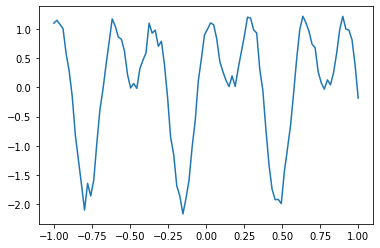

In [9]:
plt.figure()
plt.plot(x, y)
plt.show()
plt.close()

In [155]:
def get_rational_model(x, y, verbose=True, batch_size=100, epochs=1000, alpha_initializer=[1.1915, 1.5957, 0.5, 0.0218], beta_initializer=[2.383, 0.0, 1.0]):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(200),
        RationalLayer(alpha_initializer, beta_initializer),
        tf.keras.layers.Dense(200),
        RationalLayer(alpha_initializer, beta_initializer),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [80]:
def get_base_model(x, y, verbose=True, batch_size=100, epochs=1000, act='tanh'):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(200, activation=act),
        tf.keras.layers.Dense(200, activation=act),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [240]:
def get_later_model(x, y, verbose=True, batch_size=100, epochs=1000, act='relu'):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(1000, activation=act),
        tf.keras.layers.Dense(1000, activation=act),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [149]:
def get_rational_and_later_model(x, y, verbose=True, batch_size=100, epochs=1000):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(200),
        RationalLayer(),
        tf.keras.layers.Dense(200),
        RationalLayer(),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

# rational model

In [168]:
%%time
history_rat, model_rat = get_rational_model(x, y, verbose=False, batch_size=100, epochs=10000, alpha_initializer=[1.1915, 1.5957, 0.5, 0.0218], beta_initializer=[2.383, 0.0, 1.0])

CPU times: user 32.4 s, sys: 6.58 s, total: 39 s
Wall time: 17.1 s


In [169]:
model_rat.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 200)               400       
_________________________________________________________________
rational_layer_33 (RationalL (None, 200)               1400      
_________________________________________________________________
dense_77 (Dense)             (None, 200)               40200     
_________________________________________________________________
rational_layer_34 (RationalL (None, 200)               1400      
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 201       
Total params: 43,601
Trainable params: 43,601
Non-trainable params: 0
_________________________________________________________________


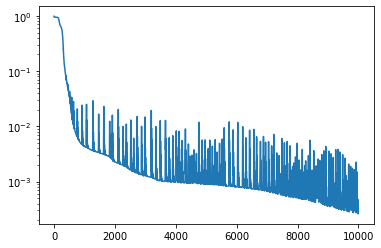

In [170]:
plt.figure()
plt.plot(history_rat.history['loss'])
plt.yscale('log')

In [171]:
yhat_rat = model_rat.predict(x)

In [172]:
yRes_rat = y-yhat_rat

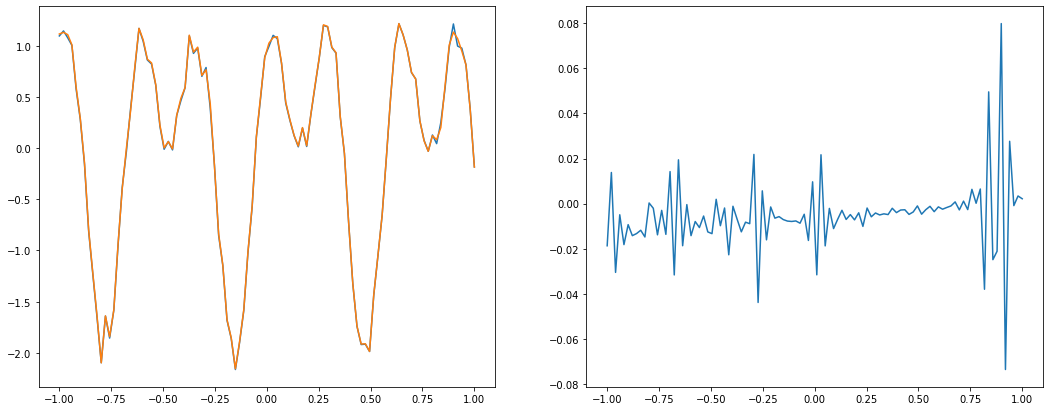

In [173]:
plot_prediction_and_error(x, y, model_rat)

In [88]:
# second step

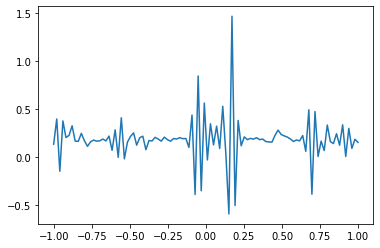

In [95]:
plt.figure()
plt.plot(x, yRes_rat*10)

In [140]:
%%time
# history2_rat, model2_rat = get_rational_model(x, yRes_rat, False, epochs=1000)
history2_rat, model2_rat = get_later_model(x, yRes_rat, False, epochs=10000)

CPU times: user 3min 30s, sys: 6.61 s, total: 3min 37s
Wall time: 40.6 s


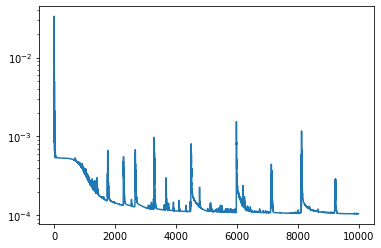

In [141]:
plt.figure()
plt.plot(history2_rat.history['loss'])
plt.yscale('log')

In [142]:
yhat2_rat = model2_rat.predict(x)

In [143]:
yRes2_rat = yRes_rat-yhat2_rat

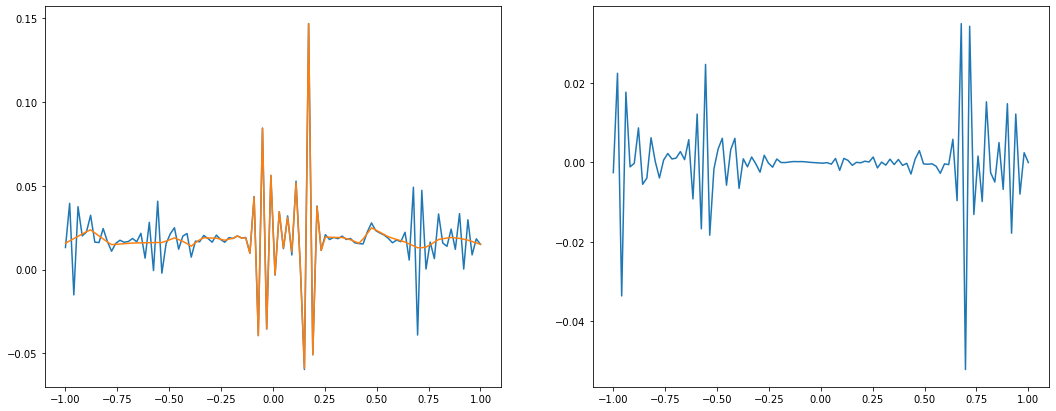

In [144]:
plot_prediction_and_error(x, yRes_rat, model2_rat)

In [147]:
yhat_multistep = model_rat.predict(x) + model2_rat.predict(x)

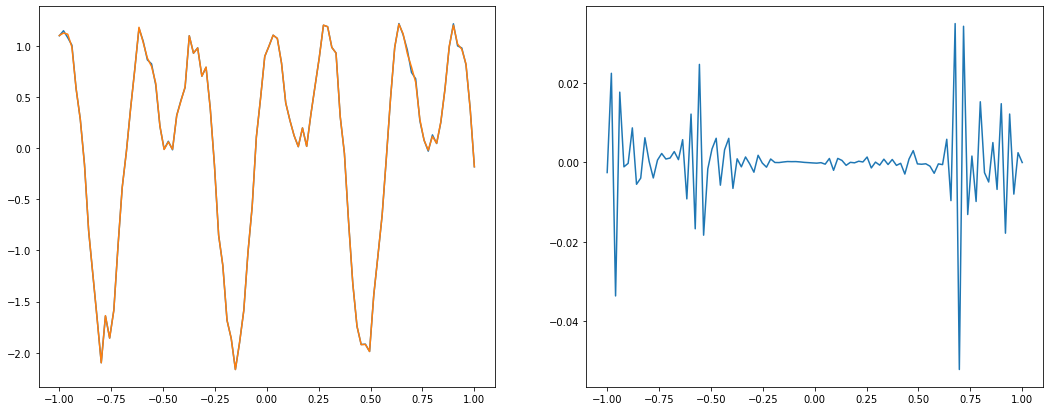

In [148]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep)

In [150]:
%%time
history_both, model_both = get_rational_and_later_model(x, y, verbose=False, epochs=10000)

CPU times: user 4min 43s, sys: 2min 3s, total: 6min 47s
Wall time: 1min 21s


In [151]:
model_both.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 200)               400       
_________________________________________________________________
rational_layer_25 (RationalL (None, 200)               1400      
_________________________________________________________________
dense_63 (Dense)             (None, 200)               40200     
_________________________________________________________________
rational_layer_26 (RationalL (None, 200)               1400      
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              201000    
_________________________________________________________________
dense_65 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_66 (Dense)             (None, 1)               

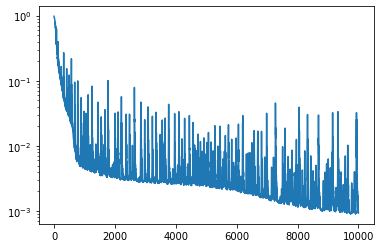

In [152]:
plt.figure()
plt.plot(history_both.history['loss'])
plt.yscale('log')

In [153]:
yhat_both = model_both.predict(x)

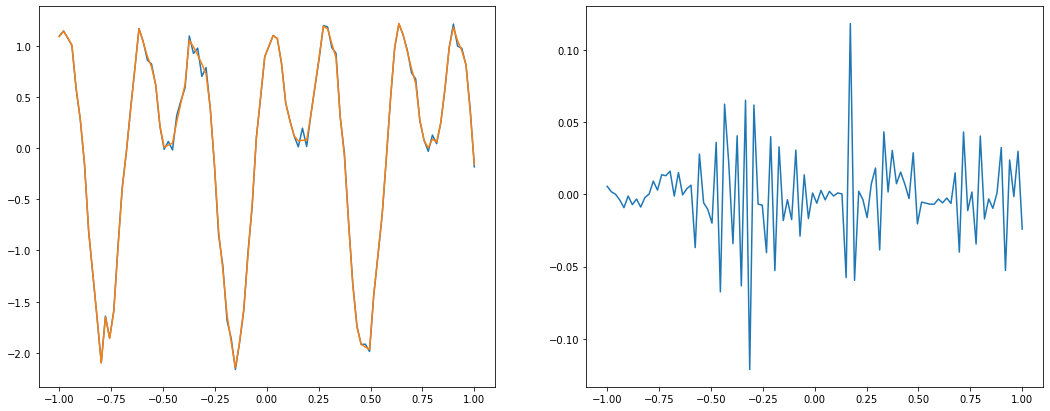

In [154]:
plot_prediction_and_error(x, y, model_both)

## using 2-step method

In [210]:
%%time
history, model = get_base_model(x, y, verbose=False, act='tanh', epochs=10000)

CPU times: user 20.6 s, sys: 3.19 s, total: 23.8 s
Wall time: 10.9 s


In [211]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 200)               400       
_________________________________________________________________
dense_86 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


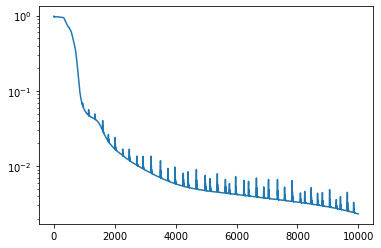

In [212]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

In [213]:
yhat = model.predict(x)

In [214]:
yRes = y-yhat

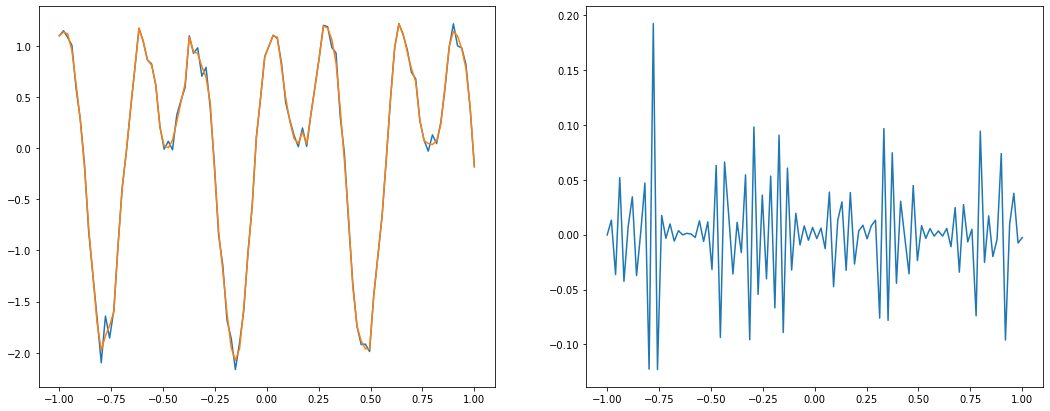

In [215]:
plot_prediction_and_error(x, y, model)

In [ ]:
%%time
history2, model2 = get_later_model(x, yRes, False, epochs=30000, act='relu')
# history2, model2 = get_later_model(x, yRes, False, epochs=30000, act='tanh')

In [ ]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [ ]:
yhat2 = model2.predict(x)

In [ ]:
yRes2 = yRes-yhat2

In [ ]:
plot_prediction_and_error(x, yRes, model2)

In [ ]:
yhat_multistep = model.predict(x) + model2.predict(x)

In [ ]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep)

In [ ]:
yhat_multistep_loss = tf.keras.losses.mean_squared_error(y, yhat_multistep)

In [ ]:
plt.figure()
plt.scatter(x, yhat_multistep_loss)
plt.yscale('log')
plt.ylim(1e-12, 1)